In [1]:
import visualize_background as vb
import visualize_foreground as vf
import visualize_rhs as vr
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def read_elliptic_vars(filename):
    with h5py.File(filename, 'r') as f:
        dvy_dy = f['dvy_dy'][:]
        dvz_dz = f['dvz_dz'][:]
        dvz_dy = f['dvz_dy'][:]
        dvy_dz = f['dvy_dz'][:]
        dd_vy_ddy = f['dd_vy_ddy'][:]
        dd_vz_ddz = f['dd_vz_ddz'][:]
        dd_vy_dydz = f['dd_vy_dydz'][:]
        dd_vz_dydz = f['dd_vz_dydz'][:]
        dvy_dy_sqrd = f['dvy_dy_sqrd'][:]
        dvz_dz_sqrd = f['dvz_dz_sqrd'][:]
        first_term = f['first_term'][:]
        second_term = f['second_term'][:]
        third_term = f['third_term'][:]
        rhs = f['rhs'][:]
        rhs_manual = f['rhs_manual'][:]

    return {'dvy_dy': dvy_dy, 'dvz_dz': dvz_dz, 'dvz_dy': dvz_dy, 'dvy_dz': dvy_dz, 'dd_vy_ddy': dd_vy_ddy, 'dd_vz_ddz': dd_vz_ddz, 'dd_vy_dydz': dd_vy_dydz, 'dd_vz_dydz': dd_vz_dydz, 'dvy_dy_sqrd': dvy_dy_sqrd, 'dvz_dz_sqrd': dvz_dz_sqrd, 'first_term': first_term, 'second_term': second_term, 'rhs': rhs, 'third_term': third_term, 'rhs_manual': rhs_manual}

def read_elliptic_rhs_mpi(snap, folder):
    n_procs = vf.read_mpi_info(folder+"mpi_info.h5")
    variables_list = {key: [] for key in ['dvy_dy', 'dvz_dz', 'dvz_dy', 'dvy_dz', 'dd_vy_ddy', 'dd_vz_ddz', 'dd_vy_dydz', 'dd_vz_dydz', 'dvy_dy_sqrd', 'dvz_dz_sqrd', 'first_term', 'second_term', 'rhs', 'third_term', 'rhs_manual']}

    for i in range(n_procs):
        variable = read_elliptic_vars("{}elliptic_vars/elliptic_vars{}_{}.h5".format(folder, snap, i))

        for key in variables_list.keys():
            variables_list[key].append(variable[key])

    # Concatenating the data for each variable
    total_variables = {key: np.concatenate(variables_list[key], axis=0) for key in variables_list.keys()}
    return total_variables

In [3]:
def get_rhs_python(snap, folder):
    n_procs = vf.read_mpi_info(folder + 'mpi_info.h5')

    bg, _ = vb.read_bg_mpi(n_procs, folder)
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)

    nz_ghost = info['nz_ghost']

    p1 = fg_vars['p1'][nz_ghost:-nz_ghost]
    vz = fg_vars['vz'][nz_ghost:-nz_ghost]
    vy = fg_vars['vy'][nz_ghost:-nz_ghost]
    rho1 = fg_vars['rho1'][nz_ghost:-nz_ghost]
    dy = info['dy']
    dz = info['dz']

    rho0 = bg['rho0'][nz_ghost:-nz_ghost]
    g = bg['g'][nz_ghost:-nz_ghost]

    vars = {}

    vars['dvy_dy'] = (np.roll(vy, -1, axis=1) - np.roll(vy, 1, axis=1)) / (2*dy)
    vars['dvy_dz'] = (np.roll(vy, -1, axis=0) - np.roll(vy, 1, axis=0)) / (2*dz)
    vars['dvz_dy'] = (np.roll(vz, -1, axis=1) - np.roll(vz, 1, axis=1)) / (2*dy)
    vars['dvz_dz'] = (np.roll(vz, -1, axis=0) - np.roll(vz, 1, axis=0)) / (2*dz)
    vars['dd_vy_ddy'] = (np.roll(vy, -1, axis=1) - 2*vy + np.roll(vy, 1, axis=1)) / dy**2
    vars['dd_vz_ddz'] = (np.roll(vz, -1, axis=0) - 2*vz + np.roll(vz, 1, axis=0)) / dz**2
    vars['dd_vy_dydz'] = (np.roll(vars['dvy_dy'], -1, axis=0) - np.roll(vars['dvy_dy'], 1, axis=0)) / (2*dz)
    vars['dd_vz_dydz'] = (np.roll(vars['dvz_dy'], -1, axis=0) - np.roll(vars['dvz_dy'], 1, axis=0)) / (2*dz)
    vars['first_term'] = -rho0[:,np.newaxis]*(vy*vars['dd_vy_ddy'] + vz*vars['dd_vz_ddz'] + 2*vars['dvy_dz']*vars['dvz_dy'] + vars['dvy_dy']**2 + vars['dvz_dz']**2 + vz*vars['dd_vy_dydz'] + vy*vars['dd_vz_dydz'])

    drho0_dz = (np.roll(rho0, -1, axis=0) - np.roll(rho0, 1, axis=0)) / (2*dz)
    vars['second_term'] = -drho0_dz[:,np.newaxis]*(vy*vars['dvz_dy'] + vz*vars['dvz_dz'])
    
    grho1 = g[:,np.newaxis]*rho1
    vars['third_term'] = (np.roll(grho1,-1,axis=0)-np.roll(grho1,1,axis=0))/(2*dz)

    vars['rhs'] = vars['first_term'] + vars['second_term'] + vars['third_term']
    return vars

def get_lhs_python(snap, folder):
    n_procs = vf.read_mpi_info(folder + 'mpi_info.h5')
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)
    p1 = fg_vars['p1'][info['nz_ghost']:-info['nz_ghost']]
    return (np.roll(p1,1,axis=0)-2*p1+np.roll(p1,-1,axis=0))/info['dz']**2 + (np.roll(p1,1,axis=1)-2*p1+np.roll(p1,-1,axis=1))/info['dy']**2

def get_rhs_c(c_vars, snap, folder):
    n_procs = vf.read_mpi_info(folder + 'mpi_info.h5')
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)
    bg, _ = vb.read_bg_mpi(n_procs, folder)

    rho1 = fg_vars['rho1'][info['nz_ghost']:-info['nz_ghost']]
    g = bg['g'][info['nz_ghost']:-info['nz_ghost']]
    dz = info['dz']
    grho1 = g[:,np.newaxis]*rho1
    return c_vars['first_term'] + c_vars['second_term'] + (np.roll(grho1,-1,axis=0)-np.roll(grho1,1,axis=0))/(2*dz)

In [34]:
DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
RUN_NAME = "new_test12/"
SAVE_FOLDER = RUN_NAME

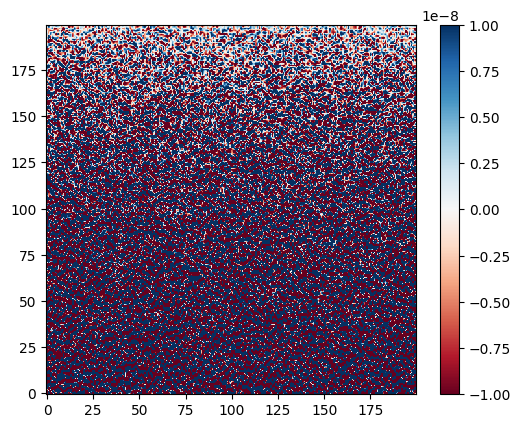

In [35]:
c_vars = read_elliptic_rhs_mpi(1, DATA_FOLDER + RUN_NAME)
lhs = get_lhs_python(1, DATA_FOLDER + RUN_NAME)

plt.imshow(c_vars['rhs'], origin='lower', cmap="RdBu", vmin=-1e-8, vmax=1e-8)
plt.colorbar()

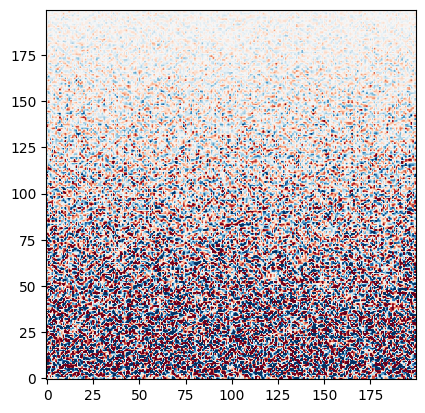

In [11]:
plt.imshow(c_vars['rhs'], origin='lower', cmap='RdBu', vmin=vmin, vmax=vmax)

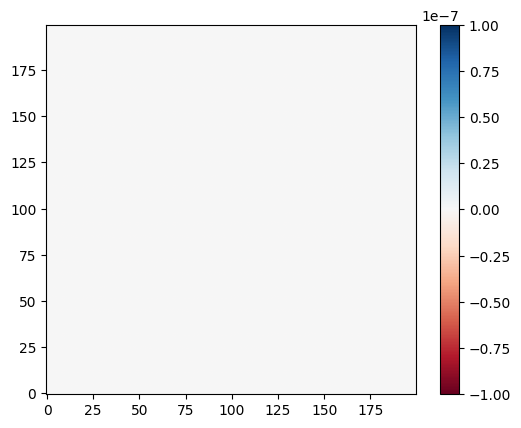

In [12]:
c_vars = read_elliptic_rhs_mpi(0, DATA_FOLDER+RUN_NAME)

vmax = 1e-7
vmin = -vmax

plt.imshow(c_vars['third_term']- c_vars['rhs'], origin='lower', cmap="RdBu", vmin=vmin, vmax=vmax)
plt.colorbar()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mn/stornext/d10/data/tabjone/data/new_test10/elliptic_vars/elliptic_vars11_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

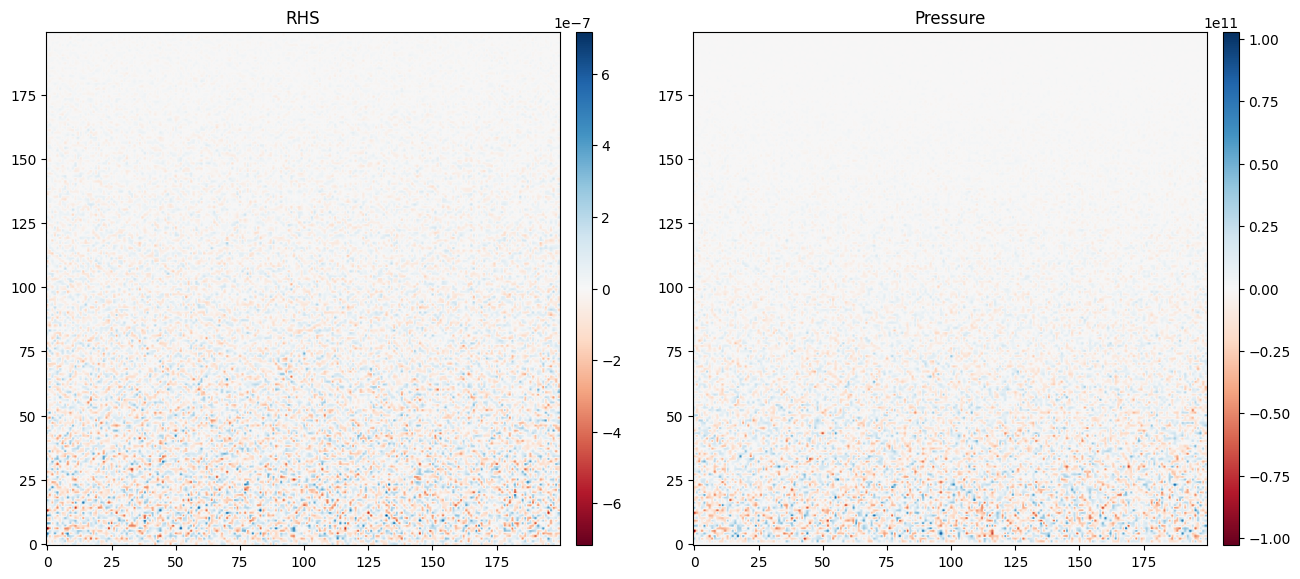

In [15]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec


def plot_rhs_vs_pressure(snap, folder, fig):
    c_vars = read_elliptic_rhs_mpi(snap, folder)
    fg, info = vf.read_fg_mpi(snap, vf.read_mpi_info(folder + 'mpi_info.h5'), folder)
    #lhs = get_lhs_python(snap, folder)

    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    vmax = np.max(np.abs(c_vars['rhs']))
    im1 = ax1.imshow(c_vars['rhs'], origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax)
            
    # Create a new axes for the colorbar next to the current subplot
    pos = ax1.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
    cbar = plt.colorbar(im1, cax=cax)

    ax2 = fig.add_subplot(gs[0, 2])
    vmax = np.max(np.abs(fg['p1'][info['nz_ghost']:-info['nz_ghost']]))
    im2 = ax2.imshow(fg['p1'][info['nz_ghost']:-info['nz_ghost']], origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax)

    # Create a new axes for the colorbar next to the current subplot
    pos = ax2.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
    cbar = plt.colorbar(im2, cax=cax)

    ax1.set_title(r'RHS')
    ax2.set_title('Pressure')


def animate(folder):
    fig = plt.figure(figsize=(16, 9)) 

    def init_animation():
        plot_rhs_vs_pressure(0, folder, fig)
    
    def update_animation(snap):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_rhs_vs_pressure(snap, folder, fig)  # Plot the new snapshot
    
    anim = animation.FuncAnimation(fig, update_animation, init_func=init_animation, frames=88, interval=1, blit=False)
    anim.save('rhs_vs_pressure.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

animate(DATA_FOLDER + RUN_NAME)

In [ ]:
snap = 0

python_vars = get_rhs_python(snap, DATA_FOLDER + RUN_NAME)
c_vars = read_elliptic_rhs_mpi(snap, DATA_FOLDER + RUN_NAME)
c_vars['rhs'] = get_rhs_c(c_vars, snap, DATA_FOLDER + RUN_NAME)
lhs = get_lhs_python(snap, DATA_FOLDER + RUN_NAME)
fg, info = vf.read_fg_mpi(snap, vf.read_mpi_info(DATA_FOLDER + RUN_NAME + 'mpi_info.h5'), DATA_FOLDER + RUN_NAME)


In [49]:
np.abs(c_vars['rhs'] - c_vars['rhs_manual'])

array([[2.34318132e-08, 2.32112939e-08, 2.30045243e-08, ...,
        2.41777452e-08, 2.39149015e-08, 2.36663014e-08],
       [2.68728250e-09, 2.65440424e-09, 2.62360808e-09, ...,
        2.79963768e-09, 2.75988355e-09, 2.72242404e-09],
       [7.37452694e-10, 7.23247185e-10, 7.10000216e-10, ...,
        7.86097575e-10, 7.68832364e-10, 7.52630085e-10],
       ...,
       [7.01380571e-11, 6.96095335e-11, 6.91200076e-11, ...,
        7.20551190e-11, 7.13993145e-11, 7.07255574e-11],
       [5.58602845e-10, 5.56785106e-10, 5.55147705e-10, ...,
        5.64667262e-10, 5.62564405e-10, 5.60557051e-10],
       [6.02720394e-09, 6.01413770e-09, 6.00184343e-09, ...,
        6.07070048e-09, 6.05552505e-09, 6.04101565e-09]])

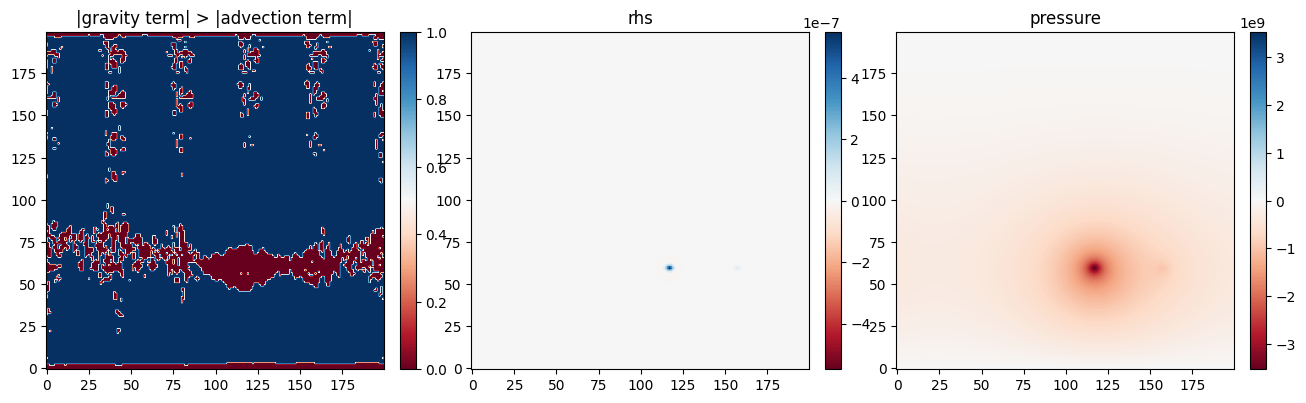

In [51]:
def plot_abs_vals(snap, folder, fig):
    python_vars = get_rhs_python(snap, folder)
    c_vars = read_elliptic_rhs_mpi(snap, folder)
    c_vars['rhs'] = get_rhs_c(c_vars, snap, folder)
    lhs = get_lhs_python(snap, folder)
    fg, info = vf.read_fg_mpi(snap, vf.read_mpi_info(folder + 'mpi_info.h5'), folder)

    gs = gridspec.GridSpec(1, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    vmax = 1
    vmin = 0
    val = np.abs(c_vars['third_term']) > np.abs(c_vars['first_term']+c_vars['second_term'])
    im1 = ax1.imshow(val, cmap='RdBu', vmin=vmin, vmax=vmax, origin='lower')
    
    # Create a new axes for the colorbar next to the current subplot
    pos = ax1.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
    cbar = plt.colorbar(im1, cax=cax)

    ax2 = fig.add_subplot(gs[0, 2])
    vmax = np.max(np.abs(c_vars['rhs']))
    vmin = -vmax
    im2 = ax2.imshow(c_vars['rhs'], cmap='RdBu', vmin=vmin, vmax=vmax, origin='lower')

    # Create a new axes for the colorbar next to the current subplot
    pos = ax2.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
    cbar = plt.colorbar(im2, cax=cax)

    ax3 = fig.add_subplot(gs[0, 4])
    vmax = np.max(np.abs(fg['p1'][info['nz_ghost']:-info['nz_ghost']]))
    vmin = -vmax
    im3 = ax3.imshow(fg['p1'][info['nz_ghost']:-info['nz_ghost']], cmap='RdBu', vmin=vmin, vmax=vmax, origin='lower')

    # Create a new axes for the colorbar next to the current subplot
    pos = ax3.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
    cbar = plt.colorbar(im3, cax=cax)

    ax1.set_title(r'|gravity term| > |advection term|')
    ax2.set_title(r'rhs')
    ax3.set_title(r'pressure')

def animate_abs_vals(folder):
    fig = plt.figure(figsize=(16, 9)) 

    def init_animation():
        plot_abs_vals(0, folder, fig)
    
    def update_animation(snap):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_abs_vals(snap, folder, fig)  # Plot the new snapshot
    
    anim = animation.FuncAnimation(fig, update_animation, init_func=init_animation, frames=79, interval=1, blit=False)
    anim.save('abs_vals.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

animate_abs_vals(DATA_FOLDER + RUN_NAME)

In [ ]:
plt.imshow(np.abs(python_vars['rhs']) - np.abs(python_vars['third_term']), origin='lower', cmap='RdBu')
plt.colorbar()
plt.title('|RHS| - |Gravity term|')



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im0 = ax[0].imshow(python_vars['rhs'], origin='lower', cmap="RdBu")
ax[0].set_title("Python RHS")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im0, cax=cax)

im1 = ax[1].imshow(c_vars['rhs'], origin='lower', cmap="RdBu")
ax[1].set_title("C RHS")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
im0 = ax[0].imshow(np.abs(python_vars['rhs']-c_vars['rhs']), origin='lower', cmap='RdBu')
ax[0].set_title(r'|RHS$_{Python}$-RHS$_C$|')

im1 = ax[1].imshow(np.abs(python_vars['first_term']-c_vars['first_term']), origin='lower', cmap='RdBu')
ax[1].set_title('First term difference')

im2 = ax[2].imshow(np.abs(python_vars['second_term']-c_vars['second_term']), origin='lower', cmap='RdBu')
ax[2].set_title('Second term difference')

for ax_, im in zip(ax, [im0, im1, im2]):
    divider = make_axes_locatable(ax_)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()

In [ ]:
#Difference between LHS and RHS for both C and Python, and pressure

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
im0 = ax[0].imshow(np.abs(python_vars['rhs']-lhs), origin='lower', cmap='RdBu')
ax[0].set_title(r'|RHS$_{Python}$-LHS$_{Python}$|')

im1 = ax[1].imshow(np.abs(c_vars['rhs']-lhs), origin='lower', cmap='RdBu')
ax[1].set_title(r'|RHS$_{C}$-LHS$_{Python}$|')

im2 = ax[2].imshow(fg['p1'][info['nz_ghost']:-info['nz_ghost']], origin='lower', cmap='RdBu')
ax[2].set_title('Pressure')

for ax_, im in zip(ax, [im0, im1, im2]):
    divider = make_axes_locatable(ax_)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()

In [ ]:
#print rhs_C and pressure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(c_vars['rhs'], origin='lower', cmap='RdBu', vmin=-6e-11, vmax=6e-11)
ax[0].set_title(r'RHS$_{C}$')

im1 = ax[1].imshow(fg['p1'][info['nz_ghost']:-info['nz_ghost']], origin='lower', cmap='RdBu', vmin=-6e6, vmax=6e6)
ax[1].set_title('Pressure')

for ax_, im in zip(ax, [im0, im1]):
    divider = make_axes_locatable(ax_)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()

In [ ]:
print("Difference between python and C derivatives:")
for key in c_vars.keys():
    print(key, np.max(np.abs(c_vars[key] - python_vars[key])))

"""
#trying to caclulate first term in C manually
first_term_c = -rho0[:,np.newaxis]*(vy*vars['dd_vy_ddy'] + vz*vars['dd_vz_ddz'] + 2*vars['dvy_dz']*vars['dvz_dy'] + vars['dvy_dy_sqrd'] + vars['dvz_dz_sqrd'] + vz*vars['dd_vy_dydz'] + vy*vars['dd_vz_dydz'])
#adn second term
second_term_c =-((np.roll(rho0,-1)-np.roll(rho0,1))/(2*dz))[:,np.newaxis]*(vy*vars['dvz_dy'] + vz*vars['dvz_dz'])"""

In [ ]:
#plt.imshow(np.abs(first_term_c-vars['first_term']), origin='lower', cmap='RdBu')
#plt.colorbar()

plt.imshow(np.abs(vy*vars['dvz_dy'] + vz*vars['dvz_dz']-(vy*vars_python['dvz_dy']+vz*vars_python['dvz_dz'])), origin='lower', cmap='RdBu')
plt.colorbar()

In [ ]:
grad_rho0 = (np.roll(rho0,-1)-np.roll(rho0,1))/(2*dz)
grad_rho0

In [ ]:
# dvy_dy, dvy_dz, dvz_dy, dvz_dz, ddvy_ddy, ddvz_ddz, ddvy_dydz, ddvz_dydz

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
im_0 = ax[0].imshow(vars_python['dvy_dz'], cmap="RdBu", origin="lower")
ax[0].set_title('Python')
fig.colorbar(im_0, ax=ax[0])

im_1 = ax[1].imshow(vars['dvy_dz'], cmap="RdBu", origin="lower")
ax[1].set_title('C')
fig.colorbar(im_1, ax=ax[1])

plt.show()

In [ ]:
# Create subplots of all the variables with colorbars

fig, ax = plt.subplots(3, 4, figsize=(20, 15))

# dvy_dy
im_00 = ax[0][0].imshow(vars['dvy_dy'], cmap="RdBu", origin="lower")
ax[0][0].set_title('dvy_dy')
fig.colorbar(im_00, ax=ax[0][0])

# dvz_dz
im_01 = ax[0][1].imshow(vars['dvz_dz'], cmap="RdBu", origin="lower")
ax[0][1].set_title('dvz_dz')
fig.colorbar(im_01, ax=ax[0][1])

# dvz_dy
im_02 = ax[0][2].imshow(vars['dvz_dy'], cmap="RdBu", origin="lower")
ax[0][2].set_title('dvz_dy')
fig.colorbar(im_02, ax=ax[0][2])

# dvy_dz
im_03 = ax[0][3].imshow(vars['dvy_dz'], cmap="RdBu", origin="lower")
ax[0][3].set_title('dvy_dz')
fig.colorbar(im_03, ax=ax[0][3])

# dd_vy_ddy
im_10 = ax[1][0].imshow(vars['dd_vy_ddy'], cmap="RdBu", origin="lower")
ax[1][0].set_title('dd_vy_ddy')
fig.colorbar(im_10, ax=ax[1][0])

# dd_vz_ddz
im_11 = ax[1][1].imshow(vars['dd_vz_ddz'], cmap="RdBu", origin="lower")
ax[1][1].set_title('dd_vz_ddz')
fig.colorbar(im_11, ax=ax[1][1])

# dd_vy_dydz
im_12 = ax[1][2].imshow(vars['dd_vy_dydz'], cmap="RdBu", origin="lower")
ax[1][2].set_title('dd_vy_dydz')
fig.colorbar(im_12, ax=ax[1][2])

# dd_vz_dydz
im_13 = ax[1][3].imshow(vars['dd_vz_dydz'], cmap="RdBu", origin="lower")
ax[1][3].set_title('dd_vz_dydz')
fig.colorbar(im_13, ax=ax[1][3])

# dvy_dy_sqrd
im_20 = ax[2][0].imshow(vars['dvy_dy_sqrd'], cmap="RdBu", origin="lower")
ax[2][0].set_title('dvy_dy_sqrd')
fig.colorbar(im_20, ax=ax[2][0])

# dvz_dz_sqrd
im_21 = ax[2][1].imshow(vars['dvz_dz_sqrd'], cmap="RdBu", origin="lower")
ax[2][1].set_title('dvz_dz_sqrd')
fig.colorbar(im_21, ax=ax[2][1])

# first_term
im_22 = ax[2][2].imshow(vars['first_term'], cmap="RdBu", origin="lower")
ax[2][2].set_title('first_term')
fig.colorbar(im_22, ax=ax[2][2])

# second_term
im_23 = ax[2][3].imshow(vars['second_term'], cmap="RdBu", origin="lower")
ax[2][3].set_title('second_term')
fig.colorbar(im_23, ax=ax[2][3])

plt.show()


In [ ]:
rhs=vars['first_term']+vars['second_term']
#[100:150,200:250]]
plt.imshow(rhs, origin="lower",cmap="RdBu",
           #vmin=-1e-5,vmax=1e-5,
           )
plt.colorbar()
print(np.max(rhs),np.min(rhs))

In [ ]:
fg_vars, info = vf.read_fg_mpi(70, 10, DATA_FOLDER + RUN_NAME)
p1=fg_vars['p1']
print(p1.shape)
lhs=(np.roll(p1,1,axis=0)-2*p1+np.roll(p1,-1,axis=0))/info['dz']**2 + (np.roll(p1,1,axis=1)-2*p1+np.roll(p1,-1,axis=1))/info['dy']**2
     

plt.figure()
plt.imshow(lhs, origin="lower",
           #vmin=-2e-6,vmax=2e-6,
           cmap="RdBu")
plt.colorbar()

In [ ]:
ddvz_dzdy = (np.roll(dvz_dz, -1, axis=1) - np.roll(dvz_dz, 1, axis=1)) / (2*dy)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
im_0 = ax[0].imshow(rhs_python, cmap="RdBu", origin="lower")
ax[0].set_title('Python')
fig.colorbar(im_0, ax=ax[0])

im_1 = ax[1].imshow(lhs, cmap="RdBu", origin="lower")
ax[1].set_title('C')
fig.colorbar(im_1, ax=ax[1])

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
im_0 = ax[0].imshow(rhs_python, cmap="RdBu", origin="lower")
ax[0].set_title('LHS')
fig.colorbar(im_0, ax=ax[0])

im_1 = ax[1].imshow(lhs, cmap="RdBu", origin="lower")
ax[1].set_title('RHS')
fig.colorbar(im_1, ax=ax[1])

plt.show()

In [ ]:
# Find max of all variables

max_dict = {key: np.max(np.abs(vars[key])) for key in vars.keys()}

# Find which variable has the largest max value

max_value = 0
max_key = ""
for key in max_dict.keys():
    if max_dict[key] > max_value:
        max_value = max_dict[key]
        max_key = key

print("The variable with the largest max value is {} with a max value of {}".format(max_key, max_value))

In [ ]:
RUN_NAME = "testing/"

In [ ]:
vars = read_elliptic_rhs_mpi(88, 10, DATA_FOLDER + RUN_NAME)

In [ ]:
# Find max of all variables

max_dict = {key: np.max(np.abs(vars[key])) for key in vars.keys()}

# Find which variable has the largest max value

max_value = 0
max_key = ""
for key in max_dict.keys():
    if max_dict[key] > max_value:
        max_value = max_dict[key]
        max_key = key

print("The variable with the largest max value is {} with a max value of {}".format(max_key, max_value))

In [55]:
K_B = 1.3807e-16
M_U = 1.66053907e-24
GAMMA = 5.0/3
MU = 0.6

c_p = K_B / (MU * M_U) / (1.0 - 1.0/GAMMA)
c_p * 0.01

3464487.3888252843

In [54]:
Ly = 6957000000.000000
Lz = 6956999999.999998
min_Hp = 736692306.616036

ky_len = int(Ly/min_Hp)
kz_len = int(Lz/min_Hp)

ky_len, kz_len

(9, 9)

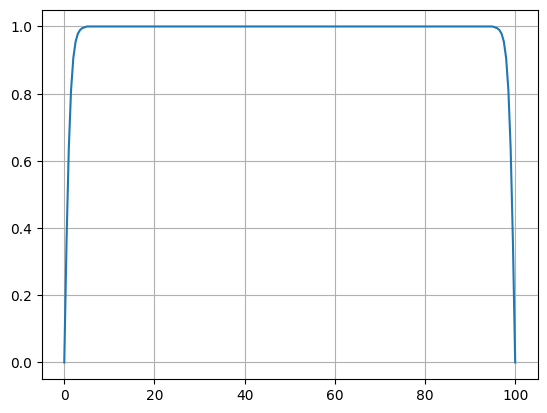

In [108]:


def sigmoid(x, L, k):
    if (x < 5):
        return L / (1.0 + np.exp(-k*(x))) - L/2
    elif (x >= 5 and x <= 95):
        return L/2
    else:
        return -L / (1.0 + np.exp(-k*(x-100))) + L/2 



x = np.linspace(0, 100, 200)
y = np.zeros(200)
for i in range(200):
    y[i] = sigmoid(x[i], 2, 1.5)

plt.plot(x, y)
#grid
plt.grid()

#sigmoid(x, 2)[0]